## Introduction
Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.
    
Hadi Fanaee-T at the University of Porto compiled this data into a CSV file. 

## Resources
The file can be downloaded from the [http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset](University of California, Irvine's website).


### Data Dictionary
Here are the details about the relevant columns 

|Feature|Description|
|:-------|:-------|
|instant | A unique sequential ID number for each row|
|dteday | The date of the rentals|
|season | The season in which the rentals occurred|
|yr | The year the rentals occurred|
|mnth | The month the rentals occurred|
|hr | The hour the rentals occurred|
|weekday | The day of the week (as a number, 0 to 7)|
|holiday | Whether or not the day was a holiday|
|workingday | Whether or not the day was a working day|
|weathersit | The weather (as a categorical variable)|
|temp | The adjusted temperature|
|temp | The temperature, on a 0-1 scale|
|hum | The humidity, on a 0-1 scale|
|windspeed | The wind speed, on a 0-1 scale|
|casual | The number of casual riders (people who hadn't previously signed up with the bike sharing program)|
|registered | The number of registered riders (people who had already signed up)|
|cnt | The total number of bike rentals (casual + registered)|



## Goal:
Predicting the total number of bikes people rented in a given hour. Predict the *cnt column* using all of the other columns, except for *casual* and *registered*. To accomplish this, create a few different machine learning models and evaluate their performance.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [3]:
from sklearn.metrics import mean_squared_error

In [55]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#### View Settings

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

## Loading Dataset

In [5]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [6]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Exploring the Dataset

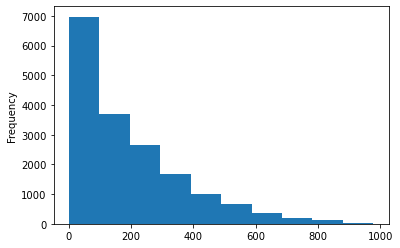

In [7]:
bike_rentals['cnt'].plot.hist()

In [8]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In the cell below, the correlation values are shown as **absolute values** sorted in descending order.

In [9]:
bike_rentals.corr()['cnt'].abs().sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

In [10]:
def assign_label(hour):
    '''The function returns the time bundled in
    either morning, afternoon, evening or night.
    The numbers 1, 2, 3, and 4 corresponds to the 
    time categories'''
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3


Lets assign the values back to the DataFrame

In [11]:
bike_rentals['time_label'] = bike_rentals["hr"].apply(assign_label)

In [12]:
bike_rentals['time_label'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

## Application of Machine Learning Algorithm

#### Choosing the right Error Metric

As our target variable, *cnt* is a continuous variable, Mean Squared Error (MSE) seems to be a good choice as an error metric for this data

#### Splitting the dataset into train and test

In [13]:
# Using Sample method 
train = bike_rentals.sample(frac=.8)

In [14]:
# Select the rows that are in bike_rentals but not in train to be in the testing set.
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]


#### Choosing the right model

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other.

 It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

#### Feature Selection

We will remove remove following columns 
- *dteday*
- *instant*

These columns contains numerical data which is not 'numerically meaningful' to our algorithm

We will also remove the columns:
- *casual*
- *registered*

These columns are derived from our target variable *cnt* 
...(causal + registered = cnt)

So having them is doesnt help 

And finally, we remove our target variable, 
- *cnt*

In [15]:
features = list(train.columns)

In [16]:
features.remove('cnt')
features.remove('casual')
features.remove('registered')
features.remove('dteday')
features.remove('instant')

In [17]:
features

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

### Linear Regression

In [18]:
# Instantiate
linreg = LinearRegression()

# Fit
linreg.fit(train[features], train['cnt'])

# Predict on train
pred_train = linreg.predict(train[features])

# Predict on test
pred_test = linreg.predict(test[features])

# Error
mse_train = mean_squared_error(train['cnt'], pred_train)
mse_test = mean_squared_error(test['cnt'], pred_test)
print('MSE on train:',mse_train)
print('MSE on test:',mse_test)

MSE on train: 17430.236818390124
MSE on test: 17689.626359866794


Observations:
- The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

What we can do?
- Remove the outliers from the data
- Optimize the model using Hyperparameter optimization
- Remove the features with no impactful correlation

### DecisionTree Regression

In [19]:
# Instantiate
tree = DecisionTreeRegressor()

# Fit
tree.fit(train[features], train['cnt'])

# Predict
pred_train = tree.predict(train[features])
pred_test = tree.predict(test[features])

# Error
mse_train = mean_squared_error(train['cnt'], pred_train)
mse_test = mean_squared_error(test['cnt'], pred_test)
print('MSE on train:',mse_train)
print('MSE on test:',mse_test)

MSE on train: 0.007012874919082213
MSE on test: 3469.003164556962


A Decision Tree with default setting of parameters has been much more accurate than the Linear Regression model, however, the discrepancy between MSE on train and MSE on test shows that the model is **overfitting**

##### Lets experiment with Decision Tree Regressor by readjusting its parameter

In [42]:
# Instantiate
tree = DecisionTreeRegressor(min_samples_leaf=2)

# Fit
tree.fit(train[features], train['cnt'])

# Predict
pred_train = tree.predict(train[features])
pred_test = tree.predict(test[features])

# Error
mse_train = mean_squared_error(train['cnt'], pred_train)
mse_test = mean_squared_error(test['cnt'], pred_test)

print('MSE on train:',mse_train)
print('MSE on test:',mse_test)

MSE on train: 346.4894267424297
MSE on test: 3054.5762929932234


Optimizing with min_sample_leaf has resulted in less overfitting, however the difference is still too large to be acceptable

In [48]:
min_sample_leaves = range(1,30)
tree_mse_dict = {}
for num in min_sample_leaves:
    # Instantiate
    tree = RandomForestRegressor(min_samples_leaf = num)

    # Fit
    tree.fit(train[features], train['cnt'])

    # Predict
    pred_train = tree.predict(train[features])
    pred_test = tree.predict(test[features])

    # Error
    mse_train = mean_squared_error(train['cnt'], pred_train)
    mse_test = mean_squared_error(test['cnt'], pred_test)
    tree_mse_dict[num] = mse_train, mse_test

In [49]:
tree_mses = pd.DataFrame(tree_mse_dict).T
tree_mses = tree_mses.rename(columns={0:'MSE train', 1:'MSE test'})
tree_mses.head()

,MSE train,MSE test
1,253.695706,1827.294591
2,504.418356,1879.122019
3,754.496283,1912.741525
4,954.811556,1992.184860
5,1140.032465,2091.411157


Text(0.5, 1.0, 'Performance of various min_sample_leaf on MSEs of Decision Tree')

<Figure size 1080x720 with 0 Axes>

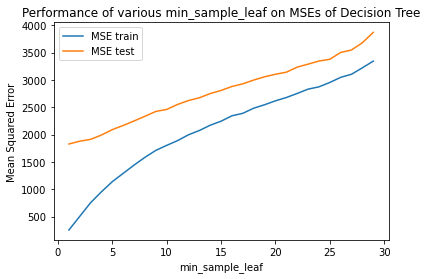

In [50]:
plt.figure(figsize=(15,10))
tree_mses.plot()
plt.xlabel('min_sample_leaf', fontsize=10)
plt.ylabel('Mean Squared Error', fontsize=10)
plt.title('Performance of various min_sample_leaf on MSEs of Decision Tree', fontsize=12)

Observation:
- If we look closely at the end, we can see that the MSE on test tends to increase enough to impact the difference

    

### Random Forests Regression

In [25]:
# Instantiate
rf = RandomForestRegressor()

# Fit
rf.fit(train[features], train['cnt'])

# Predict
pred_train = rf.predict(train[features])
pred_test = rf.predict(test[features])

# Error
mse_train = mean_squared_error(train['cnt'], pred_train)
mse_test = mean_squared_error(test['cnt'], pred_test)
print('MSE on train:',mse_train)
print('MSE on test:',mse_test)


MSE on train: 256.48940589152267
MSE on test: 1847.3556230996676


The Random Forests have even improved the accuracy even more than Decision Tree model.

#### Lets experiment with RandomForest Regressor by readjusting its parameter

In [51]:
min_sample_leaves = range(1,30)
rf_mse_dict = {}
for num in min_sample_leaves:
    # Instantiate
    rf = RandomForestRegressor(min_samples_leaf = num)

    # Fit
    rf.fit(train[features], train['cnt'])

    # Predict
    pred_train = rf.predict(train[features])
    pred_test = rf.predict(test[features])

    # Error
    mse_train = mean_squared_error(train['cnt'], pred_train)
    mse_test = mean_squared_error(test['cnt'], pred_test)
    rf_mse_dict[num] = mse_train, mse_test

In [52]:
rf_mses = pd.DataFrame(rf_mse_dict).T
rf_mses = rf_mses.rename(columns={0:'MSE train', 1:'MSE test'})
rf_mses.head()

,MSE train,MSE test
1,258.047626,1842.632366
2,506.082134,1853.751459
3,747.090219,1906.609570
4,972.179619,2032.721639
5,1132.511536,2075.988179


Text(0.5, 1.0, 'Performance of various min_sample_leaf on MSEs of Random Forest')

<Figure size 1080x720 with 0 Axes>

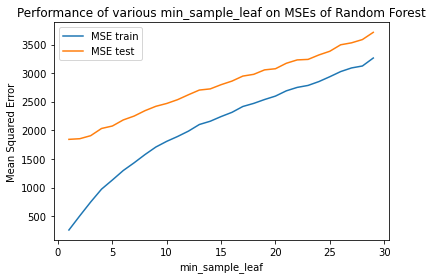

In [53]:
plt.figure(figsize=(15,10))
rf_mses.plot()
plt.xlabel('min_sample_leaf', fontsize=10)
plt.ylabel('Mean Squared Error', fontsize=10)
plt.title('Performance of various min_sample_leaf on MSEs of Random Forest', fontsize=12)

Random Forests Model performed better that Decision Trees to bring the Mean Squared Error down. 
Lets work further to enhance its performance

# TBC